In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import statsmodels.api as sm

import ema_workbench
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging)
from ema_workbench.analysis import prim


## 1. Loading the scenario dataset

In [2]:
#loading the results from a specific set of experiments just to explore what is our input data
sufficientarian_threshold = 50
full_df = pd.read_csv(f"1_drought_index\current_range\ZAs_below_{sufficientarian_threshold}-1000scenarios-1000nfe epsilon0.8-restricted.csv")

full_df.head(2)

,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,chapala_flow,calderon_lared_flow,pozos_flow,toluquilla_flow,delivered_PP1,delivered_PP2,...,min_supplied_demand,supply_percapita_GINI,supplied_demand_GINI,average_supply_percapita,energy_costs,ZAs_below_142,ZAs_below_100,ZAs_below_50,ZAs_below_128,experiment
0,-0.489862,-0.731272,0.694867,-0.236225,6.049146,2.566455,2.705694,0.104075,4.899808,1.149338,...,0.780,0.160550,0.171606,163.0,0.538057,2.0,0.0,0.0,2.0,ZAs_below_50-1000scenarios-1000nfe epsilon0.8-...
1,-0.957021,-0.562438,-0.080793,-0.710218,5.769992,0.869929,1.646554,0.052168,4.673694,1.096298,...,0.452,0.195866,0.211270,119.0,0.577617,3.0,1.0,0.0,3.0,ZAs_below_50-1000scenarios-1000nfe epsilon0.8-...


## 2. Developing the Indicator

### 2.1 Logistic Regresion for each threshold


In [3]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

log_reg_results = {}
dataframes = {}

for threshold in [50, 100, 142]:
    full_df = pd.read_csv(f"1_drought_index\current_range\ZAs_below_{threshold}-1000scenarios-1000nfe epsilon0.8-restricted.csv")
    #loading the results from the 50l/day/person 1000 scenarios with restriction optimization
    log_reg_df = full_df

    #Create a new column with False for the scenarios where there's no solution that can ensure that all ZA are above the sufficientarian threshold
    variable_of_interest = f"ZAs_below_{threshold}"
    log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] > 0

    log_reg_df=log_reg_df.loc[:][:][['chapala_flow', 'calderon_lared_flow',
        'pozos_flow', 'toluquilla_flow',"scenario_of_interest"]]
    
    dataframes = {threshold:log_reg_df}

    log_reg_df["intercept"] = np.ones(np.shape(log_reg_df)[0])
    predictors = ['chapala_flow', 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow', 'intercept']

    logit = sm.Logit(log_reg_df["scenario_of_interest"], log_reg_df[predictors])
    log_reg_results[threshold] = logit.fit()


def predict_scenario(scenario,threshold):
    # Add an intercept term
    scenario['intercept'] = 1

    # Predict the probability of the scenario being of interest
    scenario_array = np.array([scenario[col] for col in predictors])
    log_odds = np.dot(log_reg_results[threshold].params, scenario_array)
    probability = 1 / (1 + np.exp(-log_odds))
    
    return probability





Optimization terminated successfully.
         Current function value: 0.023737
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.116438
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.057203
         Iterations 12


In [13]:
for threshold in [142, 100, 50]:
    print(log_reg_results[threshold].summary2())

                            Results: Logit
Model:              Logit                Method:           MLE        
Dependent Variable: scenario_of_interest Pseudo R-squared: 0.830      
Date:               2024-08-08 09:30     AIC:              124.4070   
No. Observations:   1000                 BIC:              148.9457   
Df Model:           4                    Log-Likelihood:   -57.203    
Df Residuals:       995                  LL-Null:          -335.93    
Converged:          1.0000               LLR p-value:      2.4911e-119
No. Iterations:     12.0000              Scale:            1.0000     
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
chapala_flow           -6.2799   0.9074 -6.9205 0.0000 -8.0585 -4.5014
calderon_lared_flow    -3.1747   0.5263 -6.0323 0.0000 -4.2062 -2.1432
pozos_flow             -4.2000   0

### 2.2 Testing the logistic regression

In [18]:

new_scenario = {
    'chapala_flow': 6.1,
    'calderon_lared_flow': 1,
    'pozos_flow':0.7,
    'toluquilla_flow': 0.2
}

probability_threshold = 0.05
sufficientarian_thresholds = [50, 100, 142]

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold) 

    print(f"The likelihood that at least one ZA will fall below {threshold}l/day/person under this scenario is : {likelihood:.2f}")

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold)
     
    if likelihood>= probability_threshold:
        if threshold == sufficientarian_thresholds[0]: 
            print("Thus, the current drought state is considered HIGH")
            break
        elif threshold == sufficientarian_thresholds[1]: 
            print("Thus, the current drought state is considered  MID drought")
            break
        elif threshold == sufficientarian_thresholds[2]:
            print("Thus, the current drought state is considered LOW")
            break
    if threshold == sufficientarian_thresholds[2]: print("Thus, the current drought state is considered NO drought")
        

The likelihood that at least one ZA will fall below 50l/day/person under this scenario is : 0.00
The likelihood that at least one ZA will fall below 100l/day/person under this scenario is : 0.11
The likelihood that at least one ZA will fall below 142l/day/person under this scenario is : 1.00
Thus, the current drought state is considered  MID drought


C:\Users\ariel\AppData\Local\Temp\ipykernel_29268\2486101927.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  contour_cmap = mpl.cm.get_cmap('RdBu')


Optimization terminated successfully.
         Current function value: 0.057203
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.116438
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023737
         Iterations 14


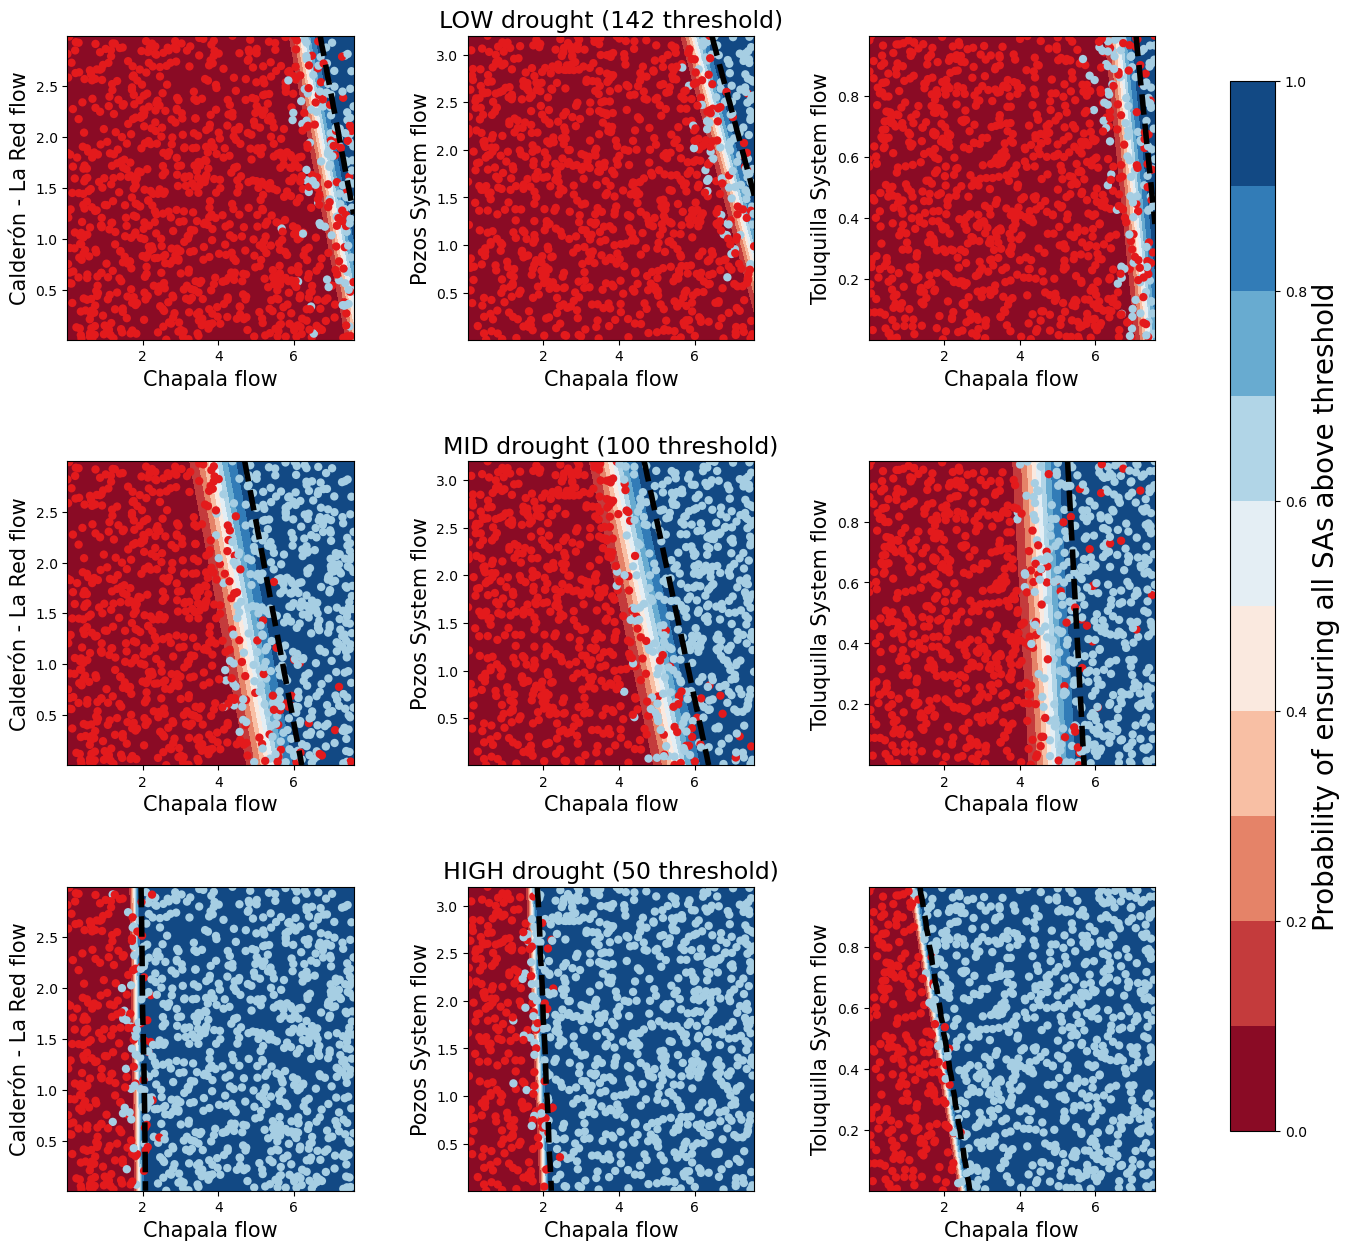

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

def load_and_prepare_data(threshold):
    full_df = pd.read_csv(f"1_drought_index/current_range/ZAs_below_{threshold}-1000scenarios-1000nfe epsilon0.8-restricted.csv")
    log_reg_df = full_df.loc[full_df["chapala_flow"] < 8][:]
    variable_of_interest = f"ZAs_below_{threshold}"
    log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] == 0
    predictors = ["chapala_flow", 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow']
    target = 'scenario_of_interest'
    dta = log_reg_df[predictors + [target]]
    return dta, predictors, target

def fitLogit(dta, predictors):
    dta['Intercept'] = np.ones(np.shape(dta)[0])
    cols = ['Intercept'] + predictors
    logit = sm.Logit(dta['scenario_of_interest'], dta[cols])
    result = logit.fit()
    return result

def plotContourMap(ax, result, constant, dta, contour_cmap, dot_cmap, levels, xgrid, ygrid, xvar, yvar, base):
    X, Y = np.meshgrid(xgrid, ygrid)
    x = X.flatten()
    y = Y.flatten()

    if constant == 'pozos_flow':  # pozos_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, y, np.ones(len(x)) * base[2], np.ones(len(x)) * base[3]])
    elif constant == 'calderon_lared_flow':  # calderon_lared_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], y, np.ones(len(x)) * base[3]])
    elif constant == 'toluquilla_flow':  # toluquilla_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], np.ones(len(x)) * base[2], y])
    else:  # chapala_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), np.ones(len(x)) * base[0], x, y, np.ones(len(x)) * base[3]])

    z = result.predict(grid)
    Z = np.reshape(z, np.shape(X))

    contourset = ax.contourf(X, Y, Z, levels, cmap=contour_cmap)
    ax.scatter(dta[xvar].values, dta[yvar].values, c=dta['scenario_of_interest'].values, edgecolor='none', cmap=dot_cmap)
    ax.set_xlim(np.min(X), np.max(X))
    ax.set_ylim(np.min(Y), np.max(Y))
    ax.set_xlabel(xvar, fontsize=12)
    ax.set_ylabel(yvar, fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

    # Add a contour line for the 95% reliability threshold
    ax.contour(X, Y, Z, levels=[0.95], colors='black', linestyles='--', linewidths=4)

    # Rename the axes
    ax.set_xlabel('Chapala flow', fontsize=15)
    if yvar == 'calderon_lared_flow':
        ax.set_ylabel('Calderón - La Red flow', fontsize=15)
    elif yvar == 'pozos_flow':
        ax.set_ylabel('Pozos System flow', fontsize=15)
    elif yvar == 'toluquilla_flow':
        ax.set_ylabel('Toluquilla System flow', fontsize=15)

    return contourset

# Define color maps and levels
dot_cmap = mpl.colors.ListedColormap(np.array([[227, 26, 28], [166, 206, 227]]) / 255.0)
contour_cmap = mpl.cm.get_cmap('RdBu')
contour_levels = np.arange(0.0, 1.05, 0.1)

# Initialize the figure
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

thresholds = [142, 100, 50]
titles = ['LOW drought (142 threshold)', 'MID drought (100 threshold)', 'HIGH drought (50 threshold)']

for i, threshold in enumerate(thresholds):
    dta, predictors, target = load_and_prepare_data(threshold)
    result = fitLogit(dta, predictors)
    
    xgrid = np.linspace(dta[predictors[0]].min(), dta[predictors[0]].max(), 100)
    ygrid = np.linspace(dta[predictors[1]].min(), dta[predictors[1]].max(), 100)
    zgrid = np.linspace(dta[predictors[2]].min(), dta[predictors[2]].max(), 100)
    tgrid = np.linspace(dta[predictors[3]].min(), dta[predictors[3]].max(), 100)
    base = [dta[predictors[0]].mean(), dta[predictors[1]].mean(), dta[predictors[2]].mean(), dta[predictors[3]].mean()]

    plotContourMap(axes[i, 0], result, 'pozos_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, ygrid, predictors[0], predictors[1], base)
    plotContourMap(axes[i, 1], result, 'calderon_lared_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, zgrid, predictors[0], predictors[2], base)
    contourset = plotContourMap(axes[i, 2], result, 'toluquilla_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, tgrid, predictors[0], predictors[3], base)

    axes[i, 1].set_title(titles[i], fontsize=17)

# Adjust subplot spacing and add a single colorbar for the entire figure
fig.subplots_adjust(wspace=0.4, hspace=0.4, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(contourset, cax=cbar_ax, cmap=contour_cmap)
cbar_ax.set_ylabel('Probability of ensuring all SAs above threshold', fontsize=20)

plt.show()


### 2.3 Making the Indicator Function

In [7]:
def load_and_prepare_data(threshold):
    full_df = pd.read_csv(f"1_drought_index/current_range/ZAs_below_{threshold}-1000scenarios-1000nfe epsilon0.8-restricted.csv")
    variable_of_interest = f"ZAs_below_{threshold}"
    full_df["scenario_of_interest"] = full_df[variable_of_interest] == 0
    predictors = ["chapala_flow", 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow']
    target = 'scenario_of_interest'
    dta = full_df[predictors + [target]]
    return dta, predictors, target

def fitLogit(dta, predictors):
    dta['Intercept'] = np.ones(np.shape(dta)[0])
    cols = ['Intercept'] + predictors
    logit = sm.Logit(dta['scenario_of_interest'], dta[cols])
    result = logit.fit()
    return result

def predict_scenario(scenario, threshold):
    dta, predictors, target = load_and_prepare_data(threshold)
    result = fitLogit(dta, predictors)
    
    # Add an intercept term to the scenario
    scenario_with_intercept = scenario.copy()
    scenario_with_intercept['Intercept'] = 1
    
    # Predict the probability
    scenario_array = np.array([scenario_with_intercept[col] for col in ['Intercept'] + predictors])
    log_odds = np.dot(result.params, scenario_array)
    probability = 1 / (1 + np.exp(-log_odds))
    
    return probability

def calculate_urban_drought_indicator(drought_state,
                                      probability_threshold=0.05,
                                      sufficientarian_thresholds=[50, 100, 142]):
    drought_conditions = "NO"
    for threshold in sufficientarian_thresholds:
        likelihood = predict_scenario(drought_state, threshold)
        print(threshold, likelihood)
        if likelihood >= probability_threshold:
            if threshold == sufficientarian_thresholds[0]: 
                drought_conditions = "HIGH"
                break
            elif threshold == sufficientarian_thresholds[1]: 
                drought_conditions = "MID"
                break
            elif threshold == sufficientarian_thresholds[2]:
                drought_conditions = "LOW"
                break

    return drought_conditions, round(likelihood, 2)

# Example usage
new_scenario = {
    'chapala_flow': 3.1,
    'calderon_lared_flow': 1.0,
    'pozos_flow': 0.5,
    'toluquilla_flow': 0.5
}

drought_index = calculate_urban_drought_indicator(new_scenario)
print(f"The drought state is: {drought_index[0]}, with a probability of: {drought_index[1]}")



Optimization terminated successfully.
         Current function value: 0.023737
         Iterations 14
50 0.9999999986060739
The drought state is: HIGH, with a probability of: 1.0


In [8]:
test = {"chapala_flow":2, "calderon_lared_flow":0.75, "pozos_flow":0.8, "toluquilla_flow":0.25}

drought_index = calculate_urban_drought_indicator(test)
print(f"The drought state is: {drought_index[0]}, with a probability of: {drought_index[1]}")


Optimization terminated successfully.
         Current function value: 0.023737
         Iterations 14
50 0.002817041888816542
Optimization terminated successfully.
         Current function value: 0.116438
         Iterations 10
100 3.144781134885366e-06
Optimization terminated successfully.
         Current function value: 0.057203
         Iterations 12
142 1.775021345106656e-17
The drought state is: NO, with a probability of: 0.0


In [9]:
drought_index = calculate_urban_drought_indicator(drought_state=new_scenario
)

print(drought_index)

Optimization terminated successfully.
         Current function value: 0.023737
         Iterations 14
50 0.9999999986060739
('HIGH', 1.0)


### 2.4 Validating the Indicator

To validate the indicator we will estimate the drought contitions for each drought state of the results of the three optimizations. By comparing the amount of ZAs under the threshold of the current optimization to the drought conditions estimated by the indicator we can assess how precise is the indicator. The results of each optimization are only usefull to assess the precision of their correspondant drought condition. For example, if we want to assess the capacity of the indicator to label HIGH drought conditions we will check how often it estimated that drought conditions are high for the cases where the optimization algorithm found 1 or more ZAs under 50l/day/person.

In [10]:
scarcity_indicator_validation_df = pd.DataFrame()

for indicator in ["ZAs_below_50", "ZAs_below_100", "ZAs_below_142"]:

    validation_df = pd.read_csv(f"1_drought_index/current_range/{indicator}-1000scenarios-1000nfe epsilon0.8-restricted.csv")
    validation_df = validation_df.loc[:][['chapala_flow', 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow', 'ZAs_below_50',"ZAs_below_100", "ZAs_below_142"]]
    validation_df["drought_state"] = ""
    validation_df["probability"] = ""
    for index, row in validation_df.iterrows():


        drought_state = row[['chapala_flow', 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow']].to_dict()
        probability_threshold = 0.05
        sufficientarian_thresholds = [50, 100, 142]

        drought_indicator = calculate_urban_drought_indicator(drought_state=drought_state, probability_threshold=probability_threshold, sufficientarian_thresholds=sufficientarian_thresholds)
        
        drought_state = drought_indicator[0]
        likelihood = drought_indicator[1]

        validation_df["probability"][index] = likelihood
        validation_df["drought_state"][index]=drought_state
        validation_df["optimization"] = indicator




    scarcity_indicator_validation_df = pd.concat([scarcity_indicator_validation_df, validation_df], axis = 0)

scarcity_indicator_validation_df.to_csv("results/drought_index_validation.csv", index=False)




SyntaxError: invalid syntax (2265326215.py, line 30)

In [ ]:
scarcity_indicator_validation_df.head()

,chapala_flow,calderon_lared_flow,pozos_flow,toluquilla_flow,ZAs_below_50,ZAs_below_100,ZAs_below_142,drought_state,probability,optimization
0,6.049146,2.566455,2.705694,0.104075,0.0,0.0,2.0,LOW,0.53,ZAs_below_50
1,5.769992,0.869929,1.646554,0.052168,0.0,1.0,3.0,MID,0.1,ZAs_below_50
2,5.622035,0.148936,2.868847,0.279797,0.0,2.0,4.0,LOW,1.0,ZAs_below_50
3,5.588388,0.403608,0.732086,0.040383,0.0,4.0,5.0,MID,0.73,ZAs_below_50
4,3.837839,0.985463,2.387142,0.363201,0.0,3.0,3.0,MID,0.93,ZAs_below_50


In [ ]:
import pandas as pd



def calculate_summary(df):
    summary = {
        'HIGH drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] > 0) & (df['drought_state'] == 'HIGH')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] == 0) & (df['drought_state'].isin(['MID', 'LOW', 'NO']))).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] == 0) & (df['drought_state'] == 'HIGH')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_50') & (df['ZAs_below_50'] > 0) & (df['drought_state'].isin(['MID', 'LOW', 'NO']))).sum(),
        },
        'MID drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] > 0) & (df['drought_state'] == 'MID')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] == 0) & (df['drought_state'].isin(['HIGH', 'LOW', 'NO']))).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] == 0) & (df['drought_state'] == 'MID')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_100') & (df['ZAs_below_100'] > 0) & (df['drought_state'].isin(['LOW', 'NO']))).sum(),
        },
        'LOW drought': {
            'True positive': ((df['optimization'] == 'ZAs_below_142') & (df['ZAs_below_142'] > 0) & (df['drought_state'] == 'LOW')).sum(),
            'True negative': ((df['optimization'] == 'ZAs_below_142') & (df['ZAs_below_142'] == 0) & (df['drought_state'] == 'NO')).sum(),
            'False positive': ((df['optimization'] == 'ZAs_below_142') & (df['ZAs_below_142'] == 0) & (df['drought_state'] == 'LOW')).sum(),
            'False negative': ((df['optimization'] == 'ZAs_below_142') & (df['ZAs_below_142'] > 0) & (df['drought_state'].isin(['NO']))).sum(),
        },
    }

    summary_df = pd.DataFrame(summary)
    summary_df.loc['Total'] = summary_df.sum()
    
    return summary_df

def calculate_ratios(summary_df):
    ratios_df = summary_df.div(summary_df.loc['Total'])
    return ratios_df

# Load your existing validation dataframe
scarcity_indicator_validation_df = pd.read_csv("results/drought_index_validation.csv")

# Calculate the summary
summary_df = calculate_summary(scarcity_indicator_validation_df)
ratios_df = calculate_ratios(summary_df)

# Combine both summary and ratios into one DataFrame for better readability
combined_df = summary_df.append(ratios_df.rename(lambda x: x + ' ratio'))

# Output the combined DataFrame to clipboard and print
combined_df.to_csv("results/drought_index_error.csv", index=False)
print(combined_df)



FileNotFoundError: [Errno 2] No such file or directory: 'results/drought_index_validation.csv'

### Creating a DataFrame with the categorized drought states for reference

In [ ]:
scarcity_indicator_reference_df = pd.read_csv("data\drought_scenarios_1000 - seed1.csv")
scarcity_indicator_reference_df["drought_condition"] = ""
scarcity_indicator_reference_df["probability"] = ""

for index, row in scarcity_indicator_reference_df.iterrows():

    drought_state = row[['chapala_flow', 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow']].to_dict()
    probability_threshold = 0.05
    sufficientarian_thresholds = [50, 100, 142]

    drought_indicator = calculate_urban_drought_indicator(drought_state=drought_state, probability_threshold=probability_threshold, sufficientarian_thresholds=sufficientarian_thresholds)
    
    drought_state = drought_indicator[0]
    likelihood = drought_indicator[1]

    scarcity_indicator_reference_df["probability"][index] = likelihood
    scarcity_indicator_reference_df["drought_condition"][index] = drought_state

scarcity_indicator_reference_df.to_csv("results/categorized_drought_states_1000states.csv")
scarcity_indicator_reference_df.head()

C:\Users\ariel\AppData\Local\Temp\ipykernel_43780\15490863.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scarcity_indicator_reference_df["probability"][index] = likelihood
C:\Users\ariel\AppData\Local\Temp\ipykernel_43780\15490863.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scarcity_indicator_reference_df["drought_condition"][index] = drought_state


,calderon_lared_flow,chapala_flow,pozos_flow,toluquilla_flow,scenario,policy,model,drought_condition,probability
0,2.566455,6.049146,2.705694,0.104075,43660,None,AMGmodel,LOW,0.53
1,0.869929,5.769992,1.646554,0.052168,87278,None,AMGmodel,MID,0.1
2,0.148936,5.622035,2.868847,0.279797,14317,None,AMGmodel,LOW,1.0
3,0.403608,5.588388,0.732086,0.040383,81932,None,AMGmodel,MID,0.73
4,0.985463,3.837839,2.387142,0.363201,95321,None,AMGmodel,MID,0.93


In [ ]:

def calculate_centroids(df, drought_index_column):
    # Get unique drought states
    drought_states = df[drought_index_column].unique()
    
    # Initialize dictionary to store centroids
    centroids = {}
    
    # Loop through each drought state and calculate the centroid
    for state in drought_states:
        state_df = df[df[drought_index_column] == state]
        centroid = state_df.mean().to_dict()
        # Remove the drought index column from the centroid calculation
        centroid.pop(drought_index_column, None)
        centroids[state] = centroid
    
    return centroids

# Example usage
df = pd.read_csv("results/categorized_drought_states_1000states.csv")  # Load your dataframe
drought_index_column = 'drought_condition'  # Replace with the name of your drought index column

centroids = calculate_centroids(df, drought_index_column)
print(centroids["HIGH"])

{'Unnamed: 0': 5031.216142270861, 'calderon_lared_flow': 2.142573091591944, 'chapala_flow': 0.8892493641441167, 'pozos_flow': 2.342841549785032, 'toluquilla_flow': 0.6162222341346006, 'scenario': 350133.69357045146, 'probability': 0.9666415868673071}


C:\Users\ariel\AppData\Local\Temp\ipykernel_15496\2095336265.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  centroid = state_df.mean().to_dict()
